## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀레니움 사용

In [66]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse # url encode
from tqdm import tqdm, tqdm_notebook
import random

In [2]:
driver = webdriver.Chrome()
url = 'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

In [3]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

In [4]:
prodItems = soup.select('ul.product_list>li.prod_item')

In [5]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

'에어메이드 스마트타워 AMC-3501A'

In [6]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t','')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [7]:
# isdecimal 숫자가아니면 False 반환
prodItems[0].select('input')[1].get('value').isdecimal()

True

##### 다나와 무선청소기 웹크롤링 수정
- 가격 외에는 안들어오도록 변환

In [8]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
            'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
            'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [9]:
def getProdItems(prodItems):
    prodData = []
    for prodItem in prodItems:
        try:
            product_name = prodItem.select('p.prod_name >a')[0].text.strip()
            product_spec = prodItem.select('div.spec_list')[0].text.strip().replace('\t','')
            if prodItem.select('input')[1].get('value').isdecimal() == True:
                product_price = prodItem.select('input')[1].get('value')
            else:
                product_price = 0
            product_reg_mon = prodItem.select('div.prod_sub_meta> dl>dd')[0].text.strip()
            prodData.append([product_name,product_spec,product_price,product_reg_mon])
        except:
            pass
    return prodData

In [10]:
# 여러페이지 검색후 크롤링하는 작업

driver = webdriver.Chrome()

# 암묵적으로 맵 자원 로드를 위해서 3초 정도 대기한다.
driver.implicitly_wait(3)

keyword = '무선청소기'
startPage = 1
totalPage = 20
# 최종 저장 리스트
prodDataTotal = []

for page in tqdm(range(startPage,totalPage+1)):
    url = getSearchPageUrl(keyword,page)
    driver.get(url)
    #페이지 로딩이 완료될 때 까지 5초 대기
    time.sleep(5)
    
    # 상품 정보 추출
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)

    prodDataTotal += prodItemList


100%|██████████| 20/20 [03:42<00:00, 11.14s/it]


In [11]:
len(prodDataTotal)

2120

In [12]:
dfprodDataTotal = pd.DataFrame(prodDataTotal)

In [13]:
dfprodDataTotal.columns=['제품명','제품스펙','최저가','날짜']

In [14]:
dfprodDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx',index= False)

##### 크롤링 데이터 전처리

In [15]:
# 저장한 엑셀을 재로드
dfprodDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfprodDanawa.tail()

,제품명,제품스펙,최저가,날짜
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000,2024.03.
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500,2024.03.
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000,2024.02.
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900,2024.02.


In [16]:
dfprodDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2120 non-null   object
 1   제품스펙    2110 non-null   object
 2   최저가     2120 non-null   int64 
 3   날짜      2120 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.4+ KB


In [17]:
# 결측치 검색
condition = dfprodDanawa['제품스펙'].isnull() == True
dfprodDanawa[condition]

,제품명,제품스펙,최저가,날짜
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0,2024.03.
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0,2024.03.
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0,2024.03.
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0,2024.03.
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0,2024.03.
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0,2024.03.


In [18]:
# 결측치가 있는 행을 삭제   *axis = 1(열), 0(행)
dfprodDanawa = dfprodDanawa.dropna(axis=0)

In [19]:
dfprodDanawa

,제품명,제품스펙,최저가,날짜
0,LG전자 오브제컬렉션 코드제로 A9S AX9884,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 250W / 소비전력: ...,890370,2023.04.
1,삼성전자 비스포크 제트 VS20B956AX,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 220W / 2022년형 / [구성]...,445230,2022.02.
2,샤오미 미홀 M22,핸디스틱청소기 / 무선 / 흡입형 / 소비전력: 320W / 2023년형 / [구성...,151050,2023.01.
3,LG전자 오브제컬렉션 코드제로 A9S AX9604,핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 250W / 소비전력: 620W / ...,715560,2023.04.
4,LG전자 오브제컬렉션 코드제로 A9S AX9988,핸디스틱청소기 / 무선 / 흡입+물걸레(동시) / 흡입력: 280W / 소비전력: ...,1229240,2023.05.
...,...,...,...,...
2114,미니센 무선 소형 청소기 MNC-100 노즐 세트,차량용청소기 / 전용브러쉬,7000,2024.03.
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000,2024.03.
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500,2024.03.
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000,2024.02.


In [20]:
condition = dfprodDanawa['최저가'] == 0

In [21]:
dfprodDanawa = dfprodDanawa[condition == 0]

In [22]:
# 행을 삭제하면 인데스가 꼬임. 인덱스 초기화
dfprodDanawa.reset_index(drop=True, inplace=True)

In [23]:
dfprodDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2059 non-null   object
 1   제품스펙    2059 non-null   object
 2   최저가     2059 non-null   int64 
 3   날짜      2059 non-null   object
dtypes: int64(1), object(3)
memory usage: 64.5+ KB


In [24]:
# 회사명, 제품명 분리 split (''.n)  n = 자를 공백의 번호
dfprodDanawa['제품명'].head()[0].split(' ',1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [25]:
# 회사명, 모델명 분리
compList = []
modelList = []
count = 0

for temp in dfprodDanawa['제품명']:
    titles = temp.split(' ',1)  # 길이가 2 배열 생성
    if (len(titles)) > 1 :
        compList.append(titles[0])
        modelList.append(titles[1])
    else:
        compList.append('')
        modelList.append(titles[0])
    count += 1
    

In [26]:
# modelList 와 compList 는 서로 같은 len 값을 가져야한다
len(modelList)
len(compList)

2059

In [27]:
# 스펙목록 데이터
specList = dfprodDanawa.loc[0,'제품스펙'].split(' / ')

In [28]:
useTime = []
suctionPow = []
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec
useTime.split(':')[1].strip()
suctionPow.split(':')[1].strip()

'250W'

In [29]:
# 카테고리, 사용시간, 흡입력 추출
CateList = []
useTimeList = []
suctionPowList = []

for spec in dfprodDanawa['제품스펙']:
    specList = spec.split(' / ')
    category = specList[0]
    CateList.append(category)
    useTimeVal = None
    suctionPowVal = None
    for temp in specList:
        if '사용시간' in temp.replace('[배터리] ',''):
            useTimeVal = temp
        elif '흡입력' in temp:
            suctionPowVal = temp

    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)','')

    else:
        useTime =''

    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow =''
    if useTime == '사용시간:':
        useTime = useTimeVal.split(' ')[2].strip().replace('(최대)','')
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)


In [30]:
useTimeList

['30분',
 '1시간',
 '',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '50분',
 '50분',
 '1시간30분',
 '1시간',
 '30분',
 '50분',
 '1시간',
 '12분',
 '30분',
 '1시간',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간',
 '30분',
 '43분',
 '43분',
 '1시간',
 '1시간',
 '40분',
 '53분',
 '40분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '50분',
 '20분',
 '10~15분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '45분',
 '',
 '18분',
 '1시간',
 '1시간',
 '30분',
 '40분',
 '42분',
 '1시간',
 '50분',
 '1시간',
 '50분',
 '30분',
 '60분',
 '30분',
 '32분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '1시간40분',
 '1시간',
 '1시간',
 '30분',
 '1시간',
 '1시간20분',
 '1시간',
 '1시간',
 '30분',
 '30분',
 '30분',
 '1시간',
 '40분',
 '30분',
 '40분',
 '30분',
 '30분',
 '30분',
 '30분',
 '1시간',
 '30분',
 '1시간',
 '',
 '57분',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '1시간',
 '35분',
 '20분',
 '50분',
 '40분',
 '45분',
 '45분',
 '30분',
 '40분',
 '1시간20분(대용량배터리기준)',
 '20분',
 '40분',
 '40분',
 '',
 '40분',
 '45분',
 '50분',
 '42분',
 '1시간',
 '1시간',
 '20분',
 '1시간',
 '28분',
 '20분',
 '50분',
 '1시간10분',
 '',
 '1시간',
 '1시간',


In [31]:
# 사용시간 단위를 통일
def convertHourToMin(time):
    try:
        if'시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        pass

In [32]:
newUseTimeList = []
for time in useTimeList :
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [33]:
# 흡입력 단위 통일 1W = 1AW = 100pa
def convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A','').replace('W','').replace(',','')
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA','').replace(',','')
            result = int(result)//100
        else:
            result = None
        
        return result
    except:
        return None

In [34]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [35]:
dfLast = pd.DataFrame()
dfLast['카테코리'] = CateList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfprodDanawa['최저가']
dfLast['사용시간(분)'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [36]:
dfLast.tail()

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
2054,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2055,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2056,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2057,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2058,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [37]:
dfLast.to_excel('./data/무선청소기_최종.xlsx',index=False)

In [38]:
dfCleaner = pd.read_excel('./data/무선청소기_최종.xlsx')

In [39]:
# 결측치 검색
dfCleaner.isnull().sum()

카테코리          0
회사명          19
제품명           0
가격            0
사용시간(분)     396
흡입력        1005
dtype: int64

In [40]:
condition = dfCleaner['회사명'].isnull() ==True
var1 = dfCleaner[condition]
dfCleaner

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
0,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9884,890370,30.0,250.0
1,핸디스틱청소기,삼성전자,비스포크 제트 VS20B956AX,445230,60.0,220.0
2,핸디스틱청소기,샤오미,미홀 M22,151050,NaN,NaN
3,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9604,715560,30.0,250.0
4,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9988,1229240,60.0,280.0
...,...,...,...,...,...,...
2054,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2055,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2056,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2057,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN


In [41]:
dfCleaner['회사명'].fillna('무명',inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16776\3649436616.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfCleaner['회사명'].fillna('무명',inplace=True)


In [42]:
dfCleaner[condition]

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
289,핸디스틱청소기,무명,LT-124,29980,240.0,80.0
998,탁상용청소기,무명,KKGTL,19800,NaN,NaN
1013,핸디스틱청소기,무명,브라프,98000,20.0,130.0
1020,창문청소기,무명,YLW6305D,26310,30.0,110.0
1042,핸디스틱청소기,무명,홈룸,72350,25.0,NaN
1047,핸디스틱청소기,무명,스웨덴,118000,NaN,100.0
1239,핸디스틱청소기,무명,ZEK-K8,157640,NaN,150.0
1293,탁상용청소기,무명,티후,5400,NaN,NaN
1311,핸디스틱청소기,무명,ZC1018,89900,25.0,NaN
1320,핸디스틱청소기,무명,SC-100,69800,30.0,NaN


In [43]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   카테코리     2059 non-null   object 
 1   회사명      2059 non-null   object 
 2   제품명      2059 non-null   object 
 3   가격       2059 non-null   int64  
 4   사용시간(분)  1663 non-null   float64
 5   흡입력      1054 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


In [44]:
dfCleaner.fillna(0,inplace=True)

In [45]:
dfCleaner['카테코리'].value_counts()

카테코리
핸디스틱청소기                1128
차량용청소기                  304
물걸레청소기                  217
침구청소기                    90
욕실청소기                    81
업소용청소기                   58
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    18
창문청소기                    11
수영장청소기                   10
스팀청소기                     5
로봇청소기                     5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [46]:
condition = dfCleaner['카테코리'].isin(['핸디스틱청소기','핸디스틱청소기+로봇청소기','진공청소기'])
dfDataFinal = dfCleaner[condition]

In [47]:
dfDataFinal.to_excel('./data/다나와_진짜최종.xlsx',index=False)

In [48]:
# 인덱스가 꼬였기때문에 재 호출
dfDataFinal = pd.read_excel('./data/다나와_진짜최종.xlsx')

In [49]:
# 흡입력 기준으로 정렬
suctionTopList = dfDataFinal.sort_values(['흡입력'],ascending = False)
suctionTopList.head()

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
103,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
327,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
12,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
470,핸디스틱청소기,행커,400W,197990,60,390
143,핸디스틱청소기,DIBEA,THE NEW,186985,50,390


In [50]:
# 사용시간 기준으로 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간(분)'],ascending = False)
useTimeTopList.head()

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
997,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
270,핸디스틱청소기,무명,LT-124,29980,240,80
812,핸디스틱청소기,기펠,BTS-5000,471980,240,0
374,핸디스틱청소기,헤몬,ST-6655,39010,180,120
660,핸디스틱청소기,무궁화전자,바로바로 MDC-900,222270,150,0


In [51]:
#사용시간, 흡입력 기준으로 정렬
topList = dfDataFinal.sort_values(['사용시간(분)','흡입력'],ascending = False)
topList.head()

,카테코리,회사명,제품명,가격,사용시간(분),흡입력
270,핸디스틱청소기,무명,LT-124,29980,240,80
812,핸디스틱청소기,기펠,BTS-5000,471980,240,0
997,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
374,핸디스틱청소기,헤몬,ST-6655,39010,180,120
650,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225450,150,0


In [52]:
# 가성비 좋은 제품 찾기
priceMean = dfDataFinal['가격'].mean()  #47만
sucationMean = dfDataFinal['흡입력'].mean()    # 117W
useTimeMean = dfDataFinal['사용시간(분)'].mean()  # 39분
print(f'평균가격: {priceMean:,.1f}원, 평균흡입력: {sucationMean:,.2f}W, 평균사용시간: {useTimeMean:,.2f}분')

평균가격: 475,905.2원, 평균흡입력: 117.79W, 평균사용시간: 39.62분


In [53]:
# 평균보다 좋은 제품들
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= sucationMean
cond3 = dfDataFinal['사용시간(분)'] >= useTimeMean

In [54]:
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
# 차트 그릴때마다 계속 실행하면 한글깨짐이나 요류 현상 발생 가능성이 높음
sns.set_style('darkgrid')

In [72]:
# 한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)
rcParams['axes.unicode_minus'] = False

In [73]:
suctionMax = chartData['흡입력'].max()
useTimeMax = chartData['사용시간(분)'].max()
useTimeMean = chartData['사용시간(분)'].mean()
sucationMean = chartData['흡입력'].mean()

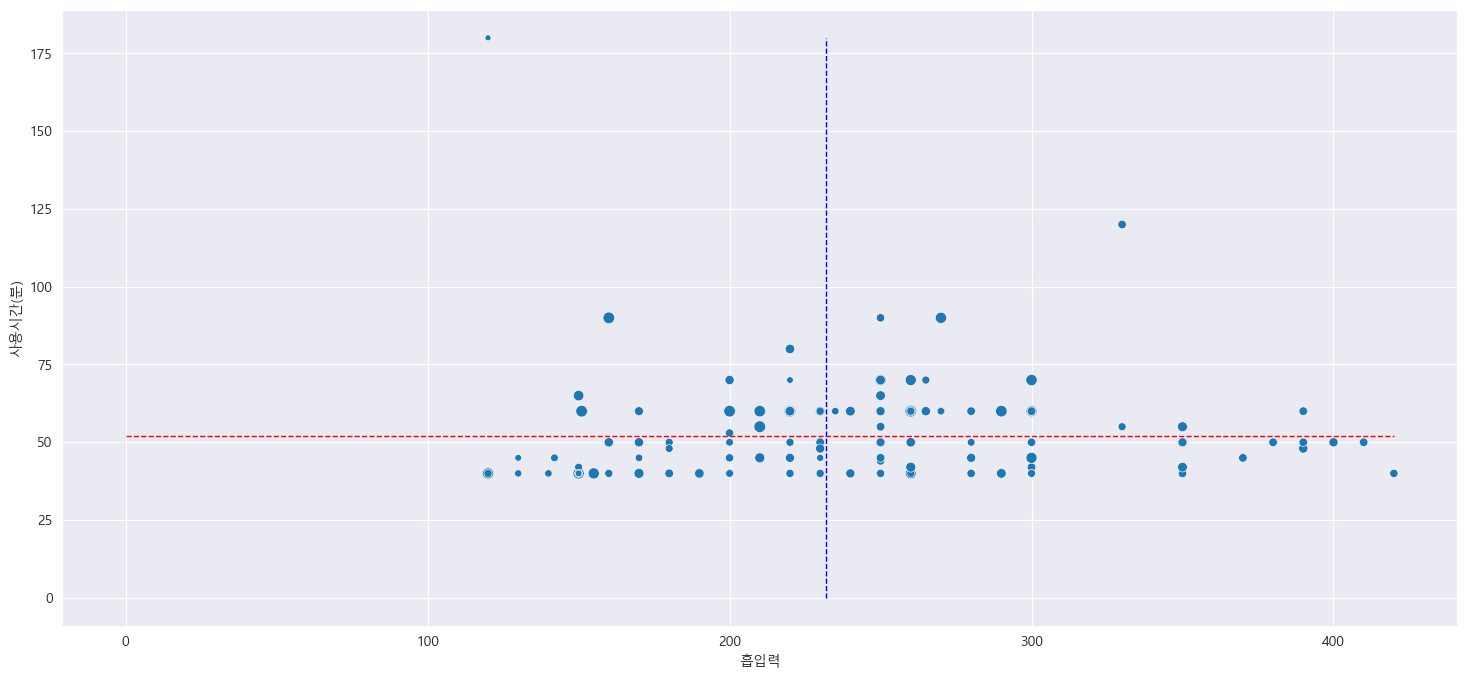

In [74]:
plt.figure(figsize=(18,8))

sns.scatterplot(data=chartData,x='흡입력',y='사용시간(분)',size = '가격',hue=chartData['카테코리'],legend=False)
plt.plot([0,suctionMax],[useTimeMean,useTimeMean],'r--',lw =1)
plt.plot([sucationMean,sucationMean],[0,useTimeMax],'b--',lw=1)

plt.show()

In [75]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

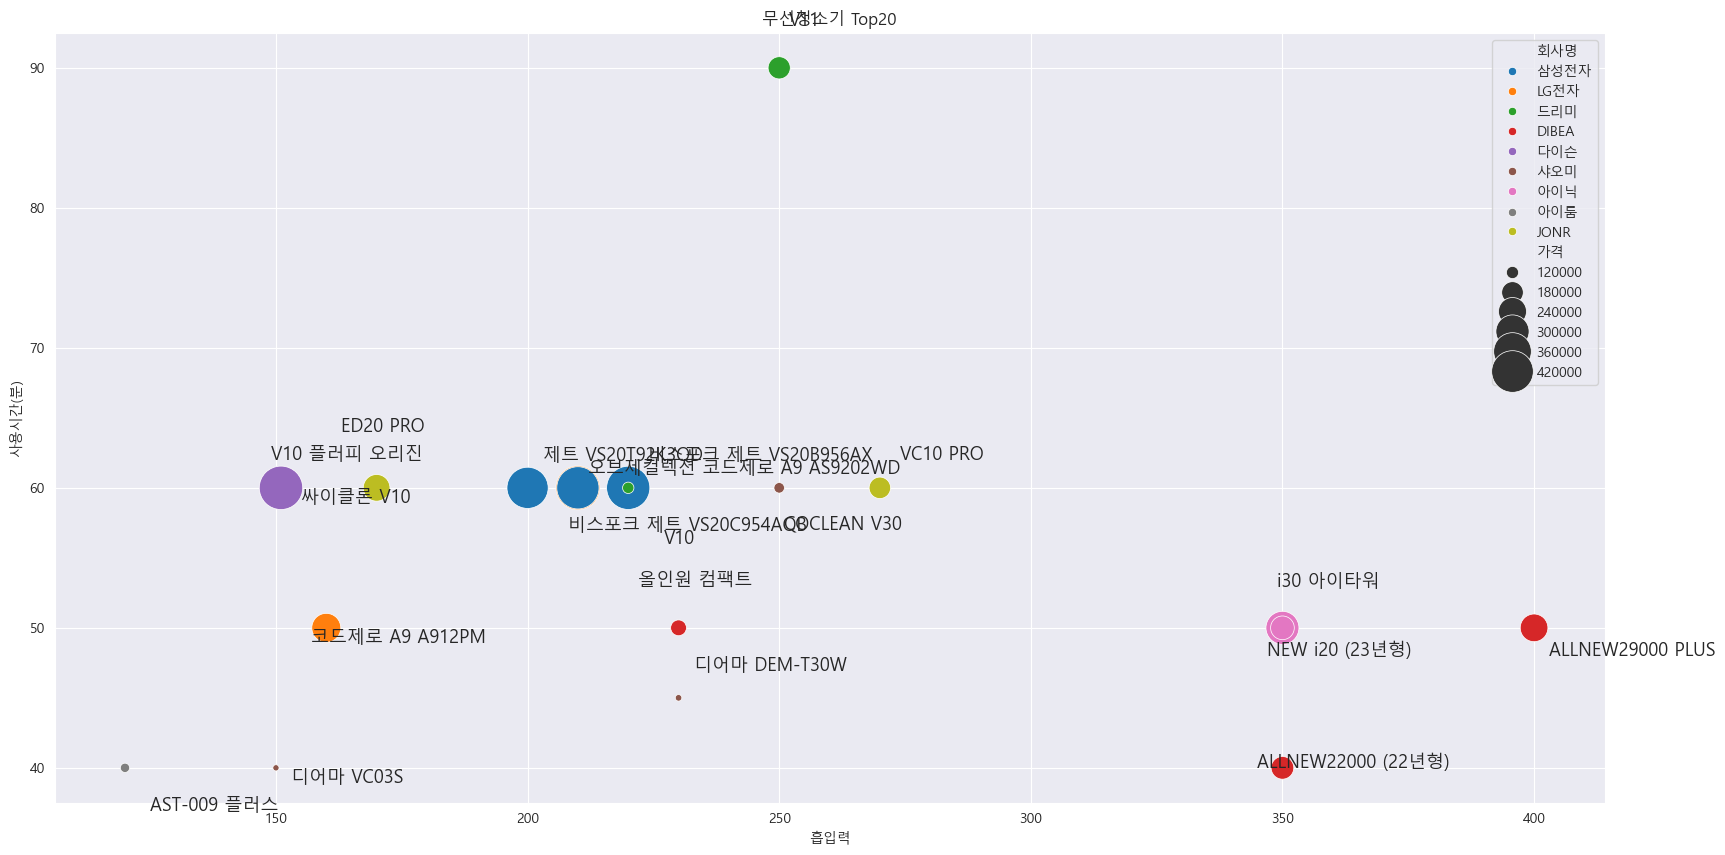

In [76]:
import random
## 인기제품 시각화

fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간(분)', size='가격', sizes=(20, 1000), hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-8, 8)
    y = row['사용시간(분)'] + random.randrange(-5, 5)
    s = row['제품명']
    plt.text(x, y, s, size=13)

plt.show()

##### 결론
- 데이터분석을 위한 전처리는 쉽지 않음
- 결과들이 예이나, 실제와 다를 수 있음